In [1]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm
import numpy as np

import tensorflow as tf

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
import zipfile

with zipfile.ZipFile('latex_data (2).zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [3]:
image_size = 160

data_root = 'latex_data'
vocab = open(os.path.join(data_root, "latex_vocab.txt")).readlines()
formulae = open(os.path.join(data_root, "formulas.norm.lst"), 'r').readlines()

char_to_idx = {x.split('\n')[0]:i for i, x in enumerate(vocab)}
char_to_idx['#UNK'] = len(char_to_idx)
char_to_idx['#START'] = len(char_to_idx)
char_to_idx['#END'] = len(char_to_idx)
idx_to_char = {y:x for x, y in char_to_idx.items()}

file_name = 'train.lst'
data_path = os.path.join(data_root, file_name)
file_list = open(data_path, 'r')

image_dir = os.path.join(data_root, 'images_processed')

set_list = []
missing = {}
for i, line in enumerate(file_list):
    form = formulae[int(line.split()[1])].strip().split()

    out_form = [char_to_idx['#START']]
    for c in form:
        try:
            out_form += [char_to_idx[c]]
        except:
            if c not in missing:
                print(c, " not found!")
                missing[c] = 1
            else:
                missing[c] += 1

            out_form += [char_to_idx['#UNK']]

    out_form += [char_to_idx['#END']]
    set_list.append([line.split()[0], out_form])

    image_file_name = line.split()[0]
    label = out_form

    if i == 5:
        break

In [4]:
class LatexDataset:
    def __init__(self, set='train', batch_size=32):
        self.data_root = 'latex_data'

        self.set = 'train'
        self.batch_size = batch_size

        self.train_dict = np.load(os.path.join(data_root, set + '_buckets.npy'), allow_pickle=True).tolist()

        self.data_length = np.sum([len(self.train_dict[x]) for x in self.train_dict.keys()])
        print("Length of %s data: " % set, self.data_length)

    def __len__(self):
        return self.data_length

    def __iter__(self):
        for keys in self.train_dict.keys():
            train_list = self.train_dict[keys]
            N_FILES = (len(train_list) // self.batch_size) * self.batch_size
            for batch_idx in range(0, N_FILES, self.batch_size):
                train_sublist = train_list[batch_idx:batch_idx + self.batch_size]
                imgs = []
                input_tokens = []
                label_tokens = []
                for x, y in train_sublist:
                    img = Image.open(os.path.join(self.data_root, 'images_processed/') + x)
                    img = img.resize((image_size, image_size))

                    img = np.asarray(img)[:,:,0][:,:,None] / 255.0

                    imgs.append(img)
                    input_tokens.append(y[:-1])
                    label_tokens.append(y[1:])

                imgs = np.asarray(imgs, dtype=np.float32).transpose(0, 1, 2, 3)
                lens = [len(x) for x in input_tokens]

                Y_input_tokens = np.zeros((self.batch_size, max(lens)), dtype=np.int32)
                for i, input_token in enumerate(input_tokens):
                    Y_input_tokens[i, :len(input_token)] = input_token

                Y_label_tokens = np.zeros((self.batch_size, max(lens)), dtype=np.int32)
                for i, label_token in enumerate(label_tokens):
                    Y_label_tokens[i, :len(label_token)] = label_token

                yield imgs, Y_input_tokens, Y_label_tokens

    __call__ = __iter__

In [5]:
train_ds_gen = LatexDataset(set='train', batch_size=32)
train_ds = tf.data.Dataset.from_generator(train_ds_gen, (tf.float32, tf.int32, tf.int32))

test_ds_gen = LatexDataset(set='test', batch_size=32)
test_ds = tf.data.Dataset.from_generator(test_ds_gen, (tf.float32, tf.int32, tf.int32))

Length of train data:  76511
Length of test data:  10355


imgs.shape:  (32, 160, 160, 1)
Y_input_tokens.shape:  (32, 84)
Y_label_tokens.shape:  (32, 84)
Y_input_token:  tf.Tensor(
[500 205 495  20 497 495  21 327 497 226 462 495   9 225 497 461 495 225
 497 312 495 477 480 497 245  20   9 469 461 495   9 464 394 495  20   7
 476 461 495  21 497 497 497 352 205 495 468 180 462 495 486 462 495 321
   8 324 497 497   4 476   5 497 495 468 476 497 468 476   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(84,), dtype=int32)
Y_label_token:  tf.Tensor(
[205 495  20 497 495  21 327 497 226 462 495   9 225 497 461 495 225 497
 312 495 477 480 497 245  20   9 469 461 495   9 464 394 495  20   7 476
 461 495  21 497 497 497 352 205 495 468 180 462 495 486 462 495 321   8
 324 497 497   4 476   5 497 495 468 476 497 468 476 501   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(84,), dtype=int32)


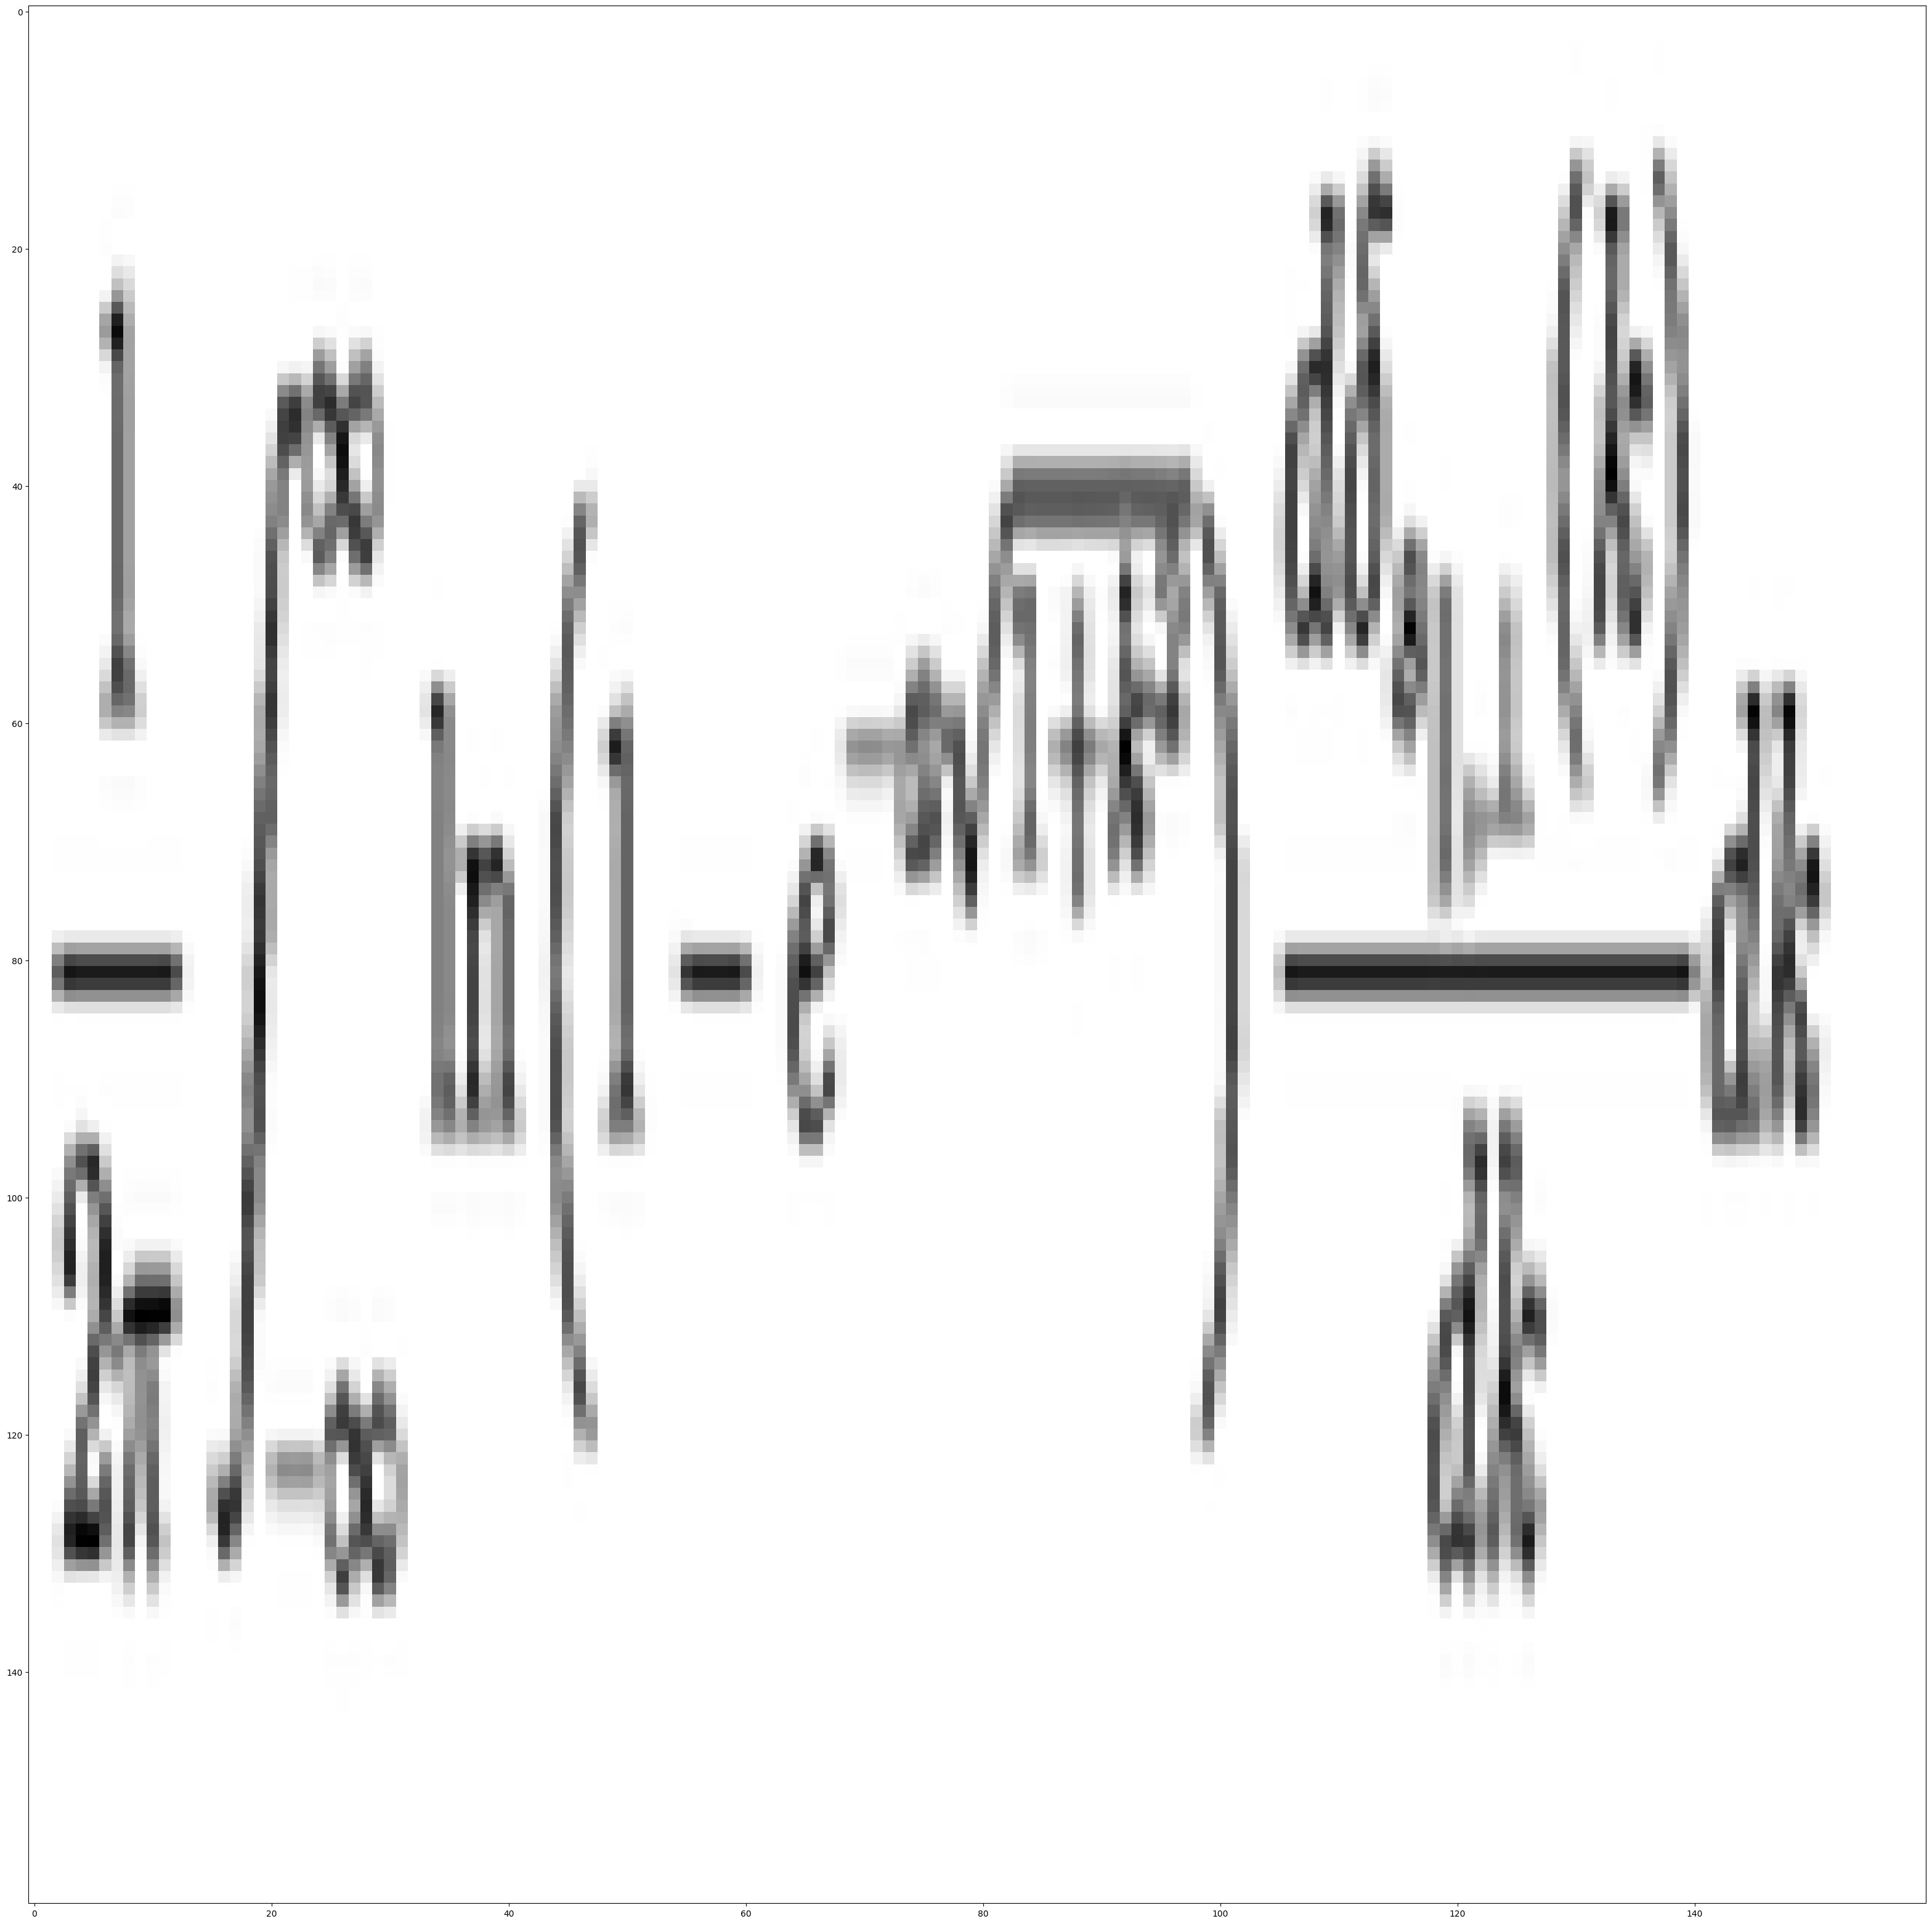

In [6]:
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from IPython.display import Image as ipythonImage
from io import StringIO
import IPython.display
import numpy as np
import cv2

displayPreds = lambda Y: display(Math(Y.split('#END')[0]))

properties = np.load(os.path.join(data_root, 'properties.npy'), allow_pickle=True).tolist()

vocab = open(os.path.join(data_root, "latex_vocab.txt")).readlines()

word_to_index = {x.split('\n')[0]:i for i, x in enumerate(vocab)}
word_to_index['#UNK'] = len(word_to_index)
word_to_index['#START'] = len(word_to_index)
word_to_index['#END'] = len(word_to_index)
index_to_word = {y:x for x, y in word_to_index.items()}

index_to_words = lambda Y: ' '.join(map(lambda x: properties['idx_to_char'][x], Y))

n = int(32)
plt.figure(figsize=(40, 40))

x = None
for idx, train_data in enumerate(train_ds):
    imgs, Y_input_tokens, Y_label_tokens = train_data

    print("imgs.shape: ", imgs.shape)
    print("Y_input_tokens.shape: ", Y_input_tokens.shape)
    print("Y_label_tokens.shape: ", Y_label_tokens.shape)

    sub_idx = -1

    img = imgs[sub_idx]
    Y_input_token = Y_input_tokens[sub_idx]
    Y_label_token = Y_label_tokens[sub_idx]
    print("Y_input_token: ", Y_input_token)
    print("Y_label_token: ", Y_label_token)

    #ax = plt.subplot(n, n, sub_idx + 1)
    #patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(img.numpy(), cmap="gray")
    #plt.imshow(img.numpy())

    #print("img.numpy().shape: ", img.numpy().shape)

    #cv2.imshow(img.numpy())
    #plt.axis("off")
    #print("img.numpy().shape: ", img.numpy().shape)

    #preds_chars = index_to_words(Y[1:].numpy()).replace('$','')
    #preds_chars = preds_chars.split('#END')[0]
    #print("preds_chars: ", preds_chars)
    #print("")
    if idx == 0:
        break

In [7]:
len(word_to_index)

502

In [8]:
data_root = 'latex_data'
set = 'test'
test_dict = np.load(os.path.join(data_root, set + '_buckets.npy'), allow_pickle=True).tolist()
test_dict.keys()

dict_keys([(606, 53), (612, 40), (557, 58), (611, 53), (588, 49), (644, 84), (611, 27), (607, 39), (514, 42), (553, 43), (591, 40), (528, 25), (516, 52), (642, 49), (601, 33), (511, 43), (523, 42), (545, 25), (524, 45), (455, 248), (551, 39), (556, 50), (585, 51), (532, 42), (539, 49), (559, 50), (533, 43), (520, 43), (504, 31), (506, 29), (517, 50), (554, 47), (528, 54), (572, 46), (546, 25), (480, 126), (353, 180), (550, 51), (680, 46), (593, 52), (680, 52), (360, 40), (575, 23), (502, 29), (512, 62), (619, 57), (625, 46), (539, 54), (537, 42), (679, 53), (588, 27), (515, 33), (545, 49), (545, 42), (540, 47), (546, 54), (544, 42), (443, 133), (628, 49), (640, 220), (514, 112), (549, 37), (523, 62), (331, 233), (522, 25), (551, 51), (414, 138), (645, 58), (586, 58), (593, 45), (527, 58), (614, 41), (526, 37), (514, 55), (506, 69), (517, 26), (565, 48), (160, 40), (516, 33), (546, 49), (512, 65), (597, 58), (598, 49), (546, 43), (523, 55), (509, 44), (676, 66), (280, 40), (608, 26), (5

In [9]:
ex_path = test_dict[(400, 160)][0][0]
image_dir = os.path.join(data_root, 'images_processed')
image_dir = os.path.join(image_dir, ex_path)

img = Image.open(image_dir).convert('YCbCr')
img = img.resize((image_size , image_size))
img = np.asarray(img)[:,:,0][:,:,None]

image.shape:  (160, 160, 1)
resized_image.shape:  (1, 160, 160, 1)
Image size: 160 X 160
Patch size: 6 X 6
Patches per image: 676
Elements per patch: 36
n:  26


'\nplt.figure(figsize=(4, 4))\nfor i, patch in enumerate(patches[0]):\n    ax = plt.subplot(n, n, i + 1)\n    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))\n\n    plt.imshow(patch_img.numpy().astype("uint8"))\n    plt.axis("off")\n'

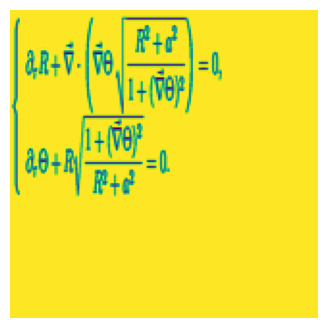

In [10]:
image_size = 160
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 512
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    return x


class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images, sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")

        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])

        return patches


class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)

        return encoded


plt.figure(figsize=(4, 4))
image = img
plt.imshow(image.astype("uint8"))
plt.axis("off")

print("image.shape: ", image.shape)
resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))
print("resized_image.shape: ", resized_image.shape)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
print("n: ", n)
'''
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))

    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
'''

In [11]:
def create_vit_classifier():
    inputs = tf.keras.Input(shape=(image_size, image_size, 1))

    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    model = tf.keras.Model(inputs=inputs, outputs=representation)

    return model

In [12]:
vit_classifier = create_vit_classifier()

In [13]:
ex_path = test_dict[(400, 160)][0][0]
image_dir = os.path.join(data_root, 'images_processed')
image_dir = os.path.join(image_dir, ex_path)

img = Image.open(image_dir).convert('YCbCr')
img = img.resize((image_size, image_size))
img = np.asarray(img)[:,:,0][:,:,None]

print(vit_classifier(np.expand_dims(img, 0)).shape)

(1, 676, 512)


## A Transformer decoder model

In [14]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()

    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
    self.token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=depth, mask_zero=True)
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq, x])

In [15]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x, use_causal_mask=True)
    x = self.add([x, attn])

    return self.layernorm(x)


class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):


    attn, attention_scores = self.mha(query=x, value=y, return_attention_scores=True)
    self.last_attention_scores = attention_scores
    x = self.add([x, attn])

    return self.layernorm(x)


class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=units, dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,key_dim=units, dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    out_seq = self.self_attention(out_seq)
    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores
    out_seq = self.ff(out_seq)

    return out_seq

In [16]:
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, vocabulary_size, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(units=vocabulary_size, **kwargs)
    self.banned_tokens = banned_tokens

  def call(self, x):
    x = self.dense(x)
    return x

In [17]:
vocabulary_size = len(word_to_index)
output_layer = TokenOutput(vocabulary_size, banned_tokens=('', '#UNK', '#START'))

In [18]:
class Captioner(tf.keras.Model):
  def __init__(self, vocabulary_size, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=200, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor

    vocab = open(os.path.join(data_root, "latex_vocab.txt")).readlines()
    self.word_to_index = {x.split('\n')[0]:i for i, x in enumerate(vocab)}
    self.word_to_index['#UNK'] = len(self.word_to_index)
    self.word_to_index['#START'] = len(self.word_to_index)
    self.word_to_index['#END'] = len(self.word_to_index)
    self.index_to_word = {y:x for x, y in self.word_to_index.items()}

    self.seq_embedding = SeqEmbedding(vocab_size=vocabulary_size, depth=units, max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate) for n in range(num_layers)]

    self.output_layer = output_layer

  def call(self, image, txt):

    image = self.feature_extractor(image)


    txt = self.seq_embedding(txt)

    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

  def simple_gen(self, image, temperature=1):
    initial = self.word_to_index['#START'] # (batch, sequence)
    initial = tf.expand_dims(initial, 0)
    initial = tf.expand_dims(initial, 0)

    tokens = initial # (batch, sequence)

    for n in range(50):
      preds = self(image[tf.newaxis, ...], tokens).numpy()  # (batch, sequence, vocab)
      preds = preds[:,-1, :]  #(batch, vocab)
      if temperature == 0:
          next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
      else:
          next = tf.random.categorical(preds / temperature, num_samples=1)  # (batch, 1)

      next = tf.cast(next, tf.int32)

      tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

      if next[0] == self.word_to_index['#END']:
        break

    words = []
    for token in tokens[0, 1:-1]:
        word = index_to_word[token.numpy()]
        words.append(word)

    result = tf.strings.reduce_join(words, axis=-1, separator=' ')

    return result.numpy().decode()

model = Captioner(vocabulary_size, feature_extractor=create_vit_classifier(), output_layer=output_layer,
                  units=512, dropout_rate=0.5, num_layers=4, num_heads=8)

In [19]:
ex_path = test_dict[(400, 160)][0][0]
image_dir = os.path.join(data_root, 'images_processed')
image_dir = os.path.join(image_dir, ex_path)

image = Image.open(image_dir).convert('YCbCr')
#image = image.resize((image_size * 4, image_size))
image = image.resize((image_size, image_size))
image = np.asarray(image)[:,:,0][:,:,None]

for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


\overleftarrow W \phantom \leftrightarrow \overleftarrow \rangle F \rightharpoonup \null \textsf ule \sl \bigsqcup \Huge \; \crcr ule \crcr \/ \smallskip 0.3 ule s \ell ule \crcr Y \rightharpoonup \null \vartheta ule \crcr \smash - \dot \smallskip \sqcup \top F \rightharpoonup \null \textsf - ule \longleftarrow \overleftarrow \bigl \big \hfill
\thinspace \textit \rgroup \rangle \S ; \right\rfloor \sharp \land \bigoplus \# \sl \bigsqcup \lq \vdots \ddagger \right\} \Longrightarrow \sp \nolinebreak \left< \overleftarrow \smallskip \Leftrightarrow F j F \varepsilon \ensuremath \sum \approx \downarrow \hspace H \natural ule \overleftarrow \chi \sl \sim \sf \lbrack \Xi \crcr \fbox \i \; \displaystyle \sc
Z \null \footnotesize 9 \llap - \rightleftharpoons \sharp \asymp \vline \downarrow \rlap \ddots \Vert \SS \null \footnotesize \right\rfloor \/ \smallskip 0.3 \dagger \c \sf z \right\rfloor \nabla \subset \sqrt \Bigr \# \c | \displaystyle \nabla \sl 0.4 g \amalg [object \Psi \smash \sim 3


In [20]:
for ds in train_ds:
   logits = model(ds[0], ds[1])
   print("logits.shape: ", logits.shape)
   break

logits.shape:  (32, 84, 502)


## Train

### Losses and metrics

In [21]:
def masked_loss(labels, preds):
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss * mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

  return loss


def masked_acc(labels, preds):
  mask = tf.cast(labels != 0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match * mask) / tf.reduce_sum(mask)

  return acc

### Callbacks

In [22]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    ex_path = test_dict[(400, 160)][0][0]
    image_dir = os.path.join(data_root, 'images_processed')
    image_dir = os.path.join(image_dir, ex_path)

    self.image = Image.open(image_dir).convert('YCbCr')
    self.image = self.image.resize((image_size, image_size))
    self.image = np.asarray(self.image)[:,:,0][:,:,None]

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)

    print()

In [23]:
callbacks = [GenerateText(), tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

In [24]:
learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(1e-4, int(100000 / 32.0 * 1000), 1e-6)
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.0001)

@tf.function
def train(ds):
    labels = ds[2]

    with tf.GradientTape() as tape:
        logits = model(ds[0], ds[1])

        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits)

        mask = (labels != 0) & (loss < 1e8)
        mask = tf.cast(mask, loss.dtype)

        loss = loss * mask
        loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)

    grads = tape.gradient(loss, model.trainable_variables)
    #(grads, _) = tf.clip_by_global_norm(grads, clip_norm=1.0)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss


@tf.function
def test(ds):
    labels = ds[2]

    preds = model(ds[0], ds[1])

    mask = tf.cast(labels != 0, tf.float32)
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)
    match = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(match * mask) / tf.reduce_sum(mask)

    return acc

In [25]:
train_data_length = train_ds_gen.data_length
print("Length of train_ds:", train_data_length)

Length of train_ds: 76511


### Train

In [26]:
os.mkdir("model")

In [45]:
import os
from tqdm import tqdm
import numpy as np
from google.colab import files

writer = tf.summary.create_file_writer("tensorboard")

# Function to find the latest saved model
def find_latest_model(save_dir):
    weights_files = [f for f in os.listdir(save_dir) if f.endswith(".h5")]
    if not weights_files:
        return None, 0  # No saved model, start from epoch 0
    #get the most recent saved file

    weights_files.sort()  # Sort the files to get the latest saved one
    latest_file = weights_files[-1]
    latest_epoch = int(latest_file.split("_")[1].split(".")[0])   # Extract epoch number
    return os.path.join(save_dir, latest_file), latest_epoch

# Directory where models are saved
save_dir = "model"

# Check for the latest model
latest_model_path, start_epoch = find_latest_model(save_dir)

# Load the model weights if found
if latest_model_path:
    print(f"Resuming training from: {latest_model_path}")
    model.load_weights(latest_model_path)
else:
    print("No saved model found. Starting training from scratch.")

# Training and Testing Loop
for epoch in range(start_epoch, 100):  # Start from the correct epoch
    print(f"Epoch {epoch + 1}")

    # Training loop with progress bar
    train_loss_sum = 0.0
    train_steps = 0
    train_bar = tqdm(train_ds, desc=f"Epoch {epoch + 1} Training", unit="batch")

    for ds_train in train_bar:
        loss = train(ds_train)
        train_loss_sum += loss.numpy()
        train_steps += 1
        train_bar.set_postfix({"Batch Loss": loss.numpy()})  # Update the progress bar with batch loss

    mean_loss_train = train_loss_sum / train_steps
    mean_perp_train = np.exp(mean_loss_train)

    # Save model weights after epoch
    if epoch % 5 == 0:
      save_path = os.path.join(save_dir, f"model_{epoch +1}.weights.h5")
      model.save_weights(save_path)
      files.download(save_path)

    # Testing loop with progress bar
    test_accuracy_sum = 0.0
    test_steps = 0
    test_bar = tqdm(test_ds, desc=f"Epoch {epoch + 1} Testing", unit="batch")
    for ds_test in test_bar:
        accuracy = test(ds_test)
        test_accuracy_sum += accuracy.numpy()
        test_steps += 1
        test_bar.set_postfix({"Batch Accuracy": accuracy.numpy()})  # Update the progress bar with batch accuracy

    mean_accuracy_test = test_accuracy_sum / test_steps

    # Logging metrics
    print(f"Mean Train Loss: {mean_loss_train:.4f}, Mean Train Perplexity: {mean_perp_train:.4f}, Mean Test Accuracy: {mean_accuracy_test:.4f}")
    with writer.as_default():
        tf.summary.scalar("mean_loss_train", mean_loss_train, step=epoch)
        tf.summary.scalar("mean_perp_train", mean_perp_train, step=epoch)
        tf.summary.scalar("mean_accuracy_test", mean_accuracy_test, step=epoch)
        writer.flush()

Resuming training from: model/model_36.weights.h5
Epoch 37


Epoch 37 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0321]
Epoch 37 Testing: 293batch [00:38,  7.66batch/s, Batch Accuracy=0.677]


Mean Train Loss: 0.0549, Mean Train Perplexity: 1.0565, Mean Test Accuracy: 0.8598
Epoch 38


Epoch 38 Training: 2380batch [15:59,  2.48batch/s, Batch Loss=0.0431]
Epoch 38 Testing: 293batch [00:38,  7.66batch/s, Batch Accuracy=0.682]


Mean Train Loss: 0.0509, Mean Train Perplexity: 1.0522, Mean Test Accuracy: 0.8570
Epoch 39


Epoch 39 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0315]
Epoch 39 Testing: 293batch [00:38,  7.66batch/s, Batch Accuracy=0.675]


Mean Train Loss: 0.0483, Mean Train Perplexity: 1.0495, Mean Test Accuracy: 0.8654
Epoch 40


Epoch 40 Training: 2380batch [15:59,  2.48batch/s, Batch Loss=0.0375]
Epoch 40 Testing: 293batch [00:38,  7.66batch/s, Batch Accuracy=0.687]


Mean Train Loss: 0.0462, Mean Train Perplexity: 1.0473, Mean Test Accuracy: 0.8681
Epoch 41


Epoch 41 Training: 2380batch [15:59,  2.48batch/s, Batch Loss=0.0253]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 41 Testing: 293batch [00:38,  7.67batch/s, Batch Accuracy=0.704]


Mean Train Loss: 0.0452, Mean Train Perplexity: 1.0462, Mean Test Accuracy: 0.8713
Epoch 42


Epoch 42 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0282]
Epoch 42 Testing: 293batch [00:38,  7.66batch/s, Batch Accuracy=0.7]


Mean Train Loss: 0.0427, Mean Train Perplexity: 1.0436, Mean Test Accuracy: 0.8707
Epoch 43


Epoch 43 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0306]
Epoch 43 Testing: 293batch [00:38,  7.67batch/s, Batch Accuracy=0.705]


Mean Train Loss: 0.0409, Mean Train Perplexity: 1.0418, Mean Test Accuracy: 0.8771
Epoch 44


Epoch 44 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0394]
Epoch 44 Testing: 293batch [00:38,  7.66batch/s, Batch Accuracy=0.725]


Mean Train Loss: 0.0392, Mean Train Perplexity: 1.0400, Mean Test Accuracy: 0.8827
Epoch 45


Epoch 45 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0219]
Epoch 45 Testing: 293batch [00:38,  7.67batch/s, Batch Accuracy=0.7]


Mean Train Loss: 0.0387, Mean Train Perplexity: 1.0394, Mean Test Accuracy: 0.8842
Epoch 46


Epoch 46 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0188]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 46 Testing: 293batch [00:38,  7.67batch/s, Batch Accuracy=0.721]


Mean Train Loss: 0.0363, Mean Train Perplexity: 1.0369, Mean Test Accuracy: 0.8834
Epoch 47


Epoch 47 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0325]
Epoch 47 Testing: 293batch [00:38,  7.67batch/s, Batch Accuracy=0.719]


Mean Train Loss: 0.0351, Mean Train Perplexity: 1.0357, Mean Test Accuracy: 0.8843
Epoch 48


Epoch 48 Training: 2380batch [15:59,  2.48batch/s, Batch Loss=0.0249]
Epoch 48 Testing: 293batch [00:38,  7.66batch/s, Batch Accuracy=0.702]


Mean Train Loss: 0.0345, Mean Train Perplexity: 1.0351, Mean Test Accuracy: 0.8892
Epoch 49


Epoch 49 Training: 2380batch [16:00,  2.48batch/s, Batch Loss=0.0191]
Epoch 49 Testing: 293batch [00:38,  7.66batch/s, Batch Accuracy=0.716]


Mean Train Loss: 0.0330, Mean Train Perplexity: 1.0335, Mean Test Accuracy: 0.8959
Epoch 50


Epoch 50 Training: 2380batch [15:59,  2.48batch/s, Batch Loss=0.0167]
Epoch 50 Testing: 293batch [00:38,  7.67batch/s, Batch Accuracy=0.731]


Mean Train Loss: 0.0325, Mean Train Perplexity: 1.0330, Mean Test Accuracy: 0.8903
Epoch 51


Epoch 51 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0224]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 51 Testing: 293batch [00:38,  7.67batch/s, Batch Accuracy=0.731]


Mean Train Loss: 0.0312, Mean Train Perplexity: 1.0317, Mean Test Accuracy: 0.8908
Epoch 52


Epoch 52 Training: 2380batch [15:59,  2.48batch/s, Batch Loss=0.0281]
Epoch 52 Testing: 293batch [00:38,  7.67batch/s, Batch Accuracy=0.753]


Mean Train Loss: 0.0308, Mean Train Perplexity: 1.0312, Mean Test Accuracy: 0.8993
Epoch 53


Epoch 53 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0216]
Epoch 53 Testing: 293batch [00:38,  7.66batch/s, Batch Accuracy=0.763]


Mean Train Loss: 0.0294, Mean Train Perplexity: 1.0299, Mean Test Accuracy: 0.9071
Epoch 54


Epoch 54 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0149]
Epoch 54 Testing: 293batch [00:38,  7.66batch/s, Batch Accuracy=0.765]


Mean Train Loss: 0.0289, Mean Train Perplexity: 1.0293, Mean Test Accuracy: 0.9080
Epoch 55


Epoch 55 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0275]
Epoch 55 Testing: 293batch [00:38,  7.67batch/s, Batch Accuracy=0.732]


Mean Train Loss: 0.0278, Mean Train Perplexity: 1.0282, Mean Test Accuracy: 0.9012
Epoch 56


Epoch 56 Training: 2380batch [15:58,  2.48batch/s, Batch Loss=0.0209]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 56 Testing: 293batch [00:38,  7.66batch/s, Batch Accuracy=0.751]


Mean Train Loss: 0.0277, Mean Train Perplexity: 1.0280, Mean Test Accuracy: 0.9087
Epoch 57


Epoch 57 Training: 1400batch [09:25,  2.47batch/s, Batch Loss=0.0127]


KeyboardInterrupt: 

## Evaluate

Length of test data:  10355
Label: 


<IPython.core.display.Math object>

Prediction: 


<IPython.core.display.Math object>

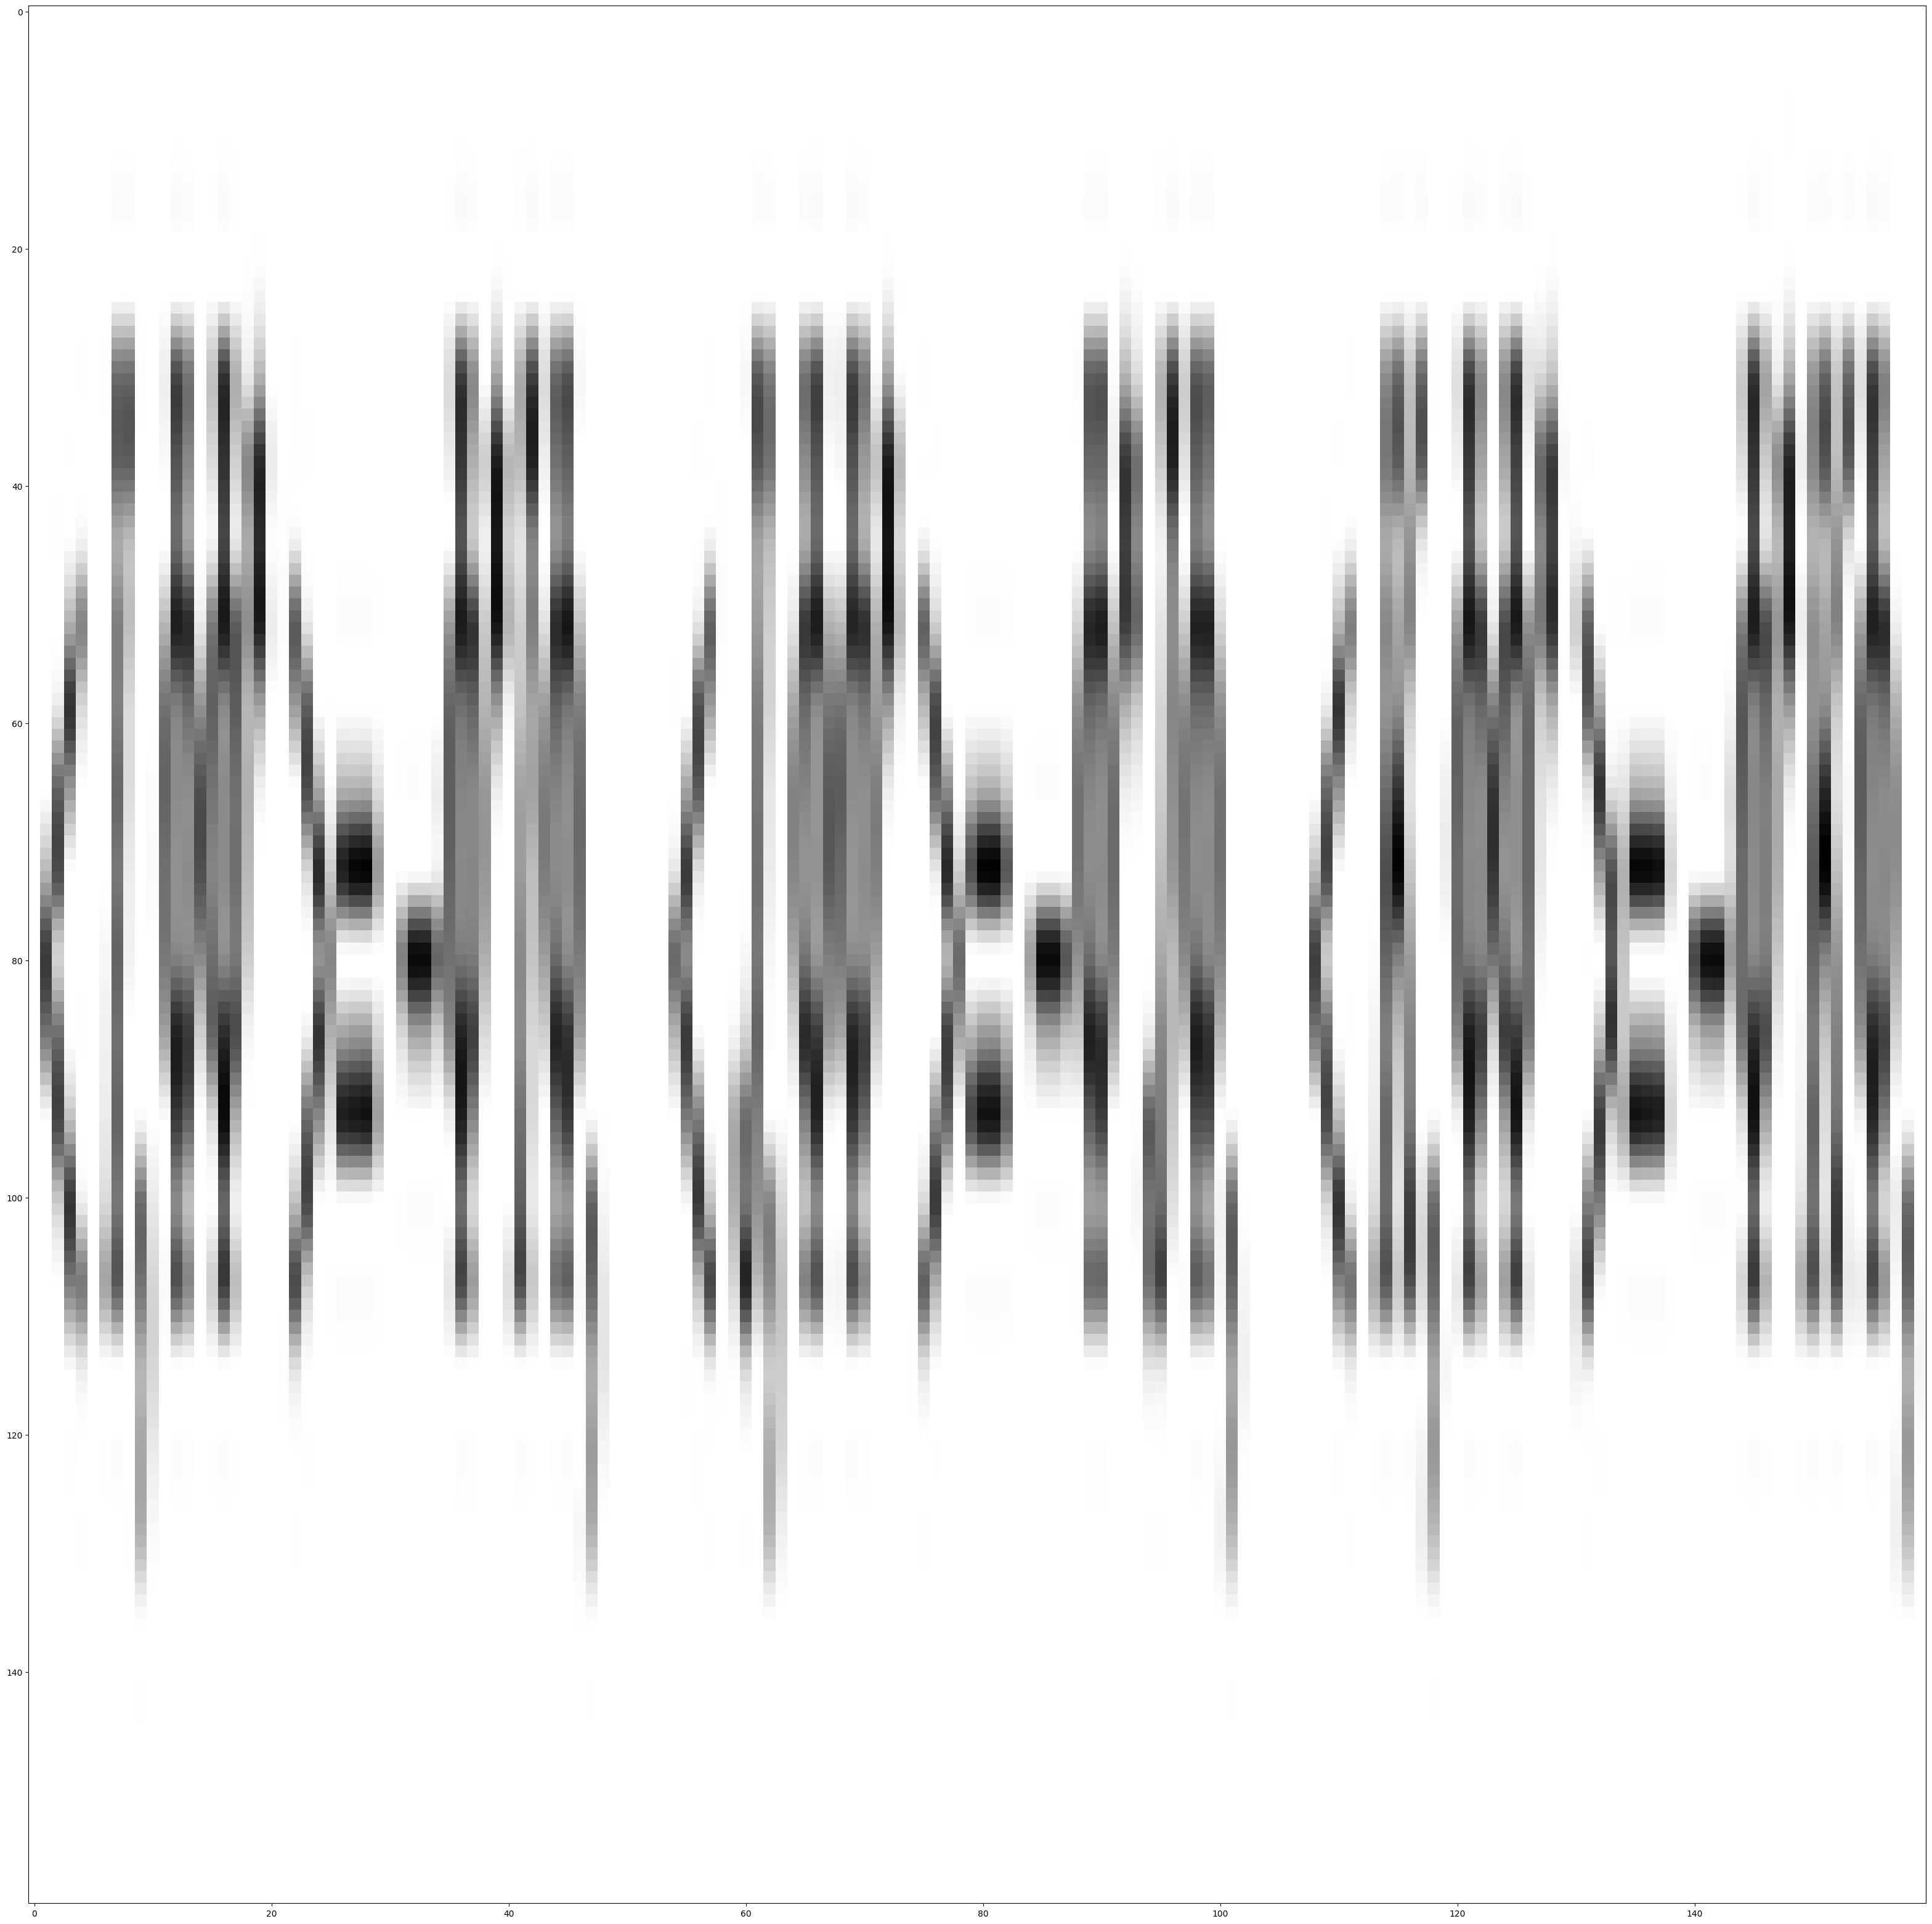

In [55]:
import random

model.load_weights("model/model_56.weights.h5")

plt.figure(figsize=(40, 40))

data_root = 'latex_data'
set = 'test'
test_dict = np.load(os.path.join(data_root, set + '_buckets.npy'), allow_pickle=True).tolist()
data_length = np.sum([len(test_dict[x]) for x in test_dict.keys()])
print("Length of %s data: " % set, data_length)

key_list = list(test_dict.keys())
key = random.choice(key_list)
test_list = test_dict[key]
test_image_info = random.choice(test_list)

img = Image.open(os.path.join(data_root, 'images_processed/') + test_image_info[0])
img = img.resize((image_size, image_size))
img = np.asarray(img)[:,:,0][:,:,None] / 255.0
plt.imshow(img, cmap="gray")

Y = np.array(test_image_info[1])

preds_chars = index_to_words(Y[1:]).replace('$','')
preds_chars = preds_chars.split('#END')[0]

print("Label: ")
displayPreds(preds_chars)

result = model.simple_gen(img, temperature=0.0)
print("Prediction: ")
displayPreds(result)

## Attention plots

In [56]:
ex_path = test_dict[(400, 160)][0][0]
image_dir = os.path.join(data_root, 'images_processed')
image_dir = os.path.join(image_dir, ex_path)

image = Image.open(image_dir).convert('YCbCr')
image = image.resize((256, 256))
image = np.asarray(img)[:,:,0][:,:,None] / 255.0

In [57]:
result = model.simple_gen(image, temperature=0.0)
result

'\\begin{array} { l {'

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

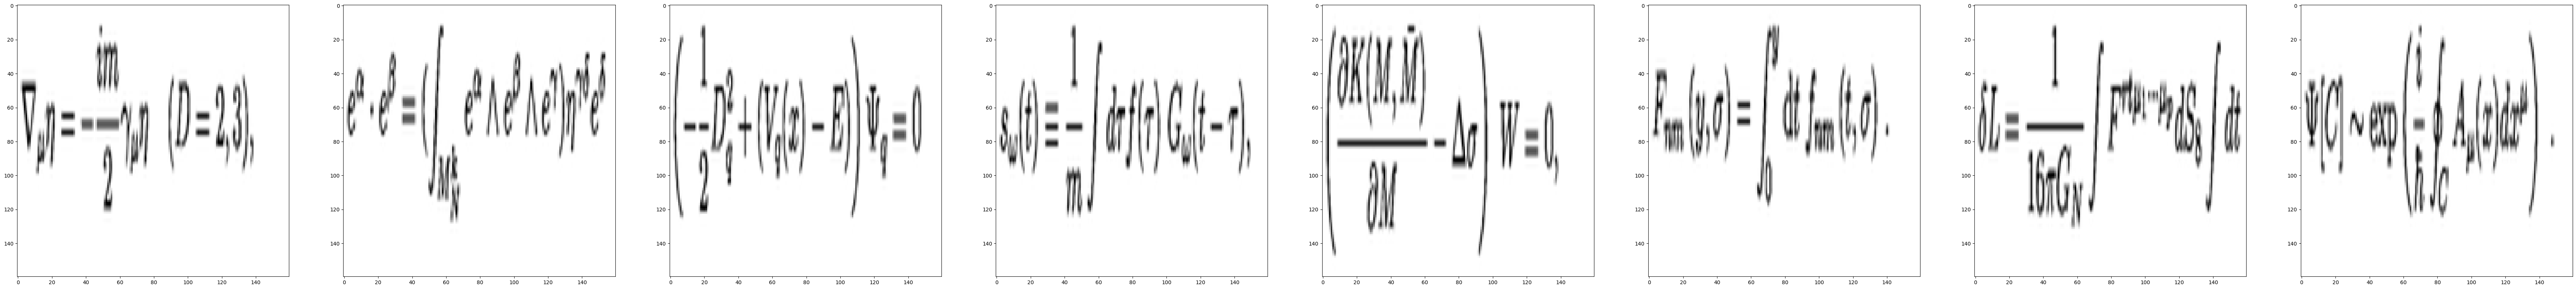

In [58]:
from IPython.display import display, Math, Latex
displayPreds = lambda Y: display(Math(Y))

step = 0

fig = plt.figure(figsize=(100, 100))

for ds in test_ds.shuffle(1000):
    images = ds[0]

    num_image = images.shape[0]
    for i in range(8):
      result = model.simple_gen(images[i].numpy(), temperature=0.0)
      displayPreds(result)

      grid_size = max(int(np.ceil(num_image / 9)), 9)
      ax = fig.add_subplot(6, grid_size, i + 1)
      img = ax.imshow(images[i].numpy(), cmap='gray')

    step += 1
    break
    #if step == 20:
    #    break

In [70]:
for ds in test_ds.shuffle(10):
    images = ds[0]
    labels = ds[1]

    num_image = images.shape[0]
    for i in range(1):
        labels_chars = index_to_words(labels.numpy()[i][1:]).replace('$','')
        labels_chars = labels_chars.split('#END')[0]
        print("Label: ")
        displayPreds(labels_chars)

        result = model.simple_gen(images[i].numpy(), temperature=0.0)

        print("Prediction: ")
        displayPreds(result)

    break

Label: 


<IPython.core.display.Math object>

Prediction: 


<IPython.core.display.Math object>

## Attention plots

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

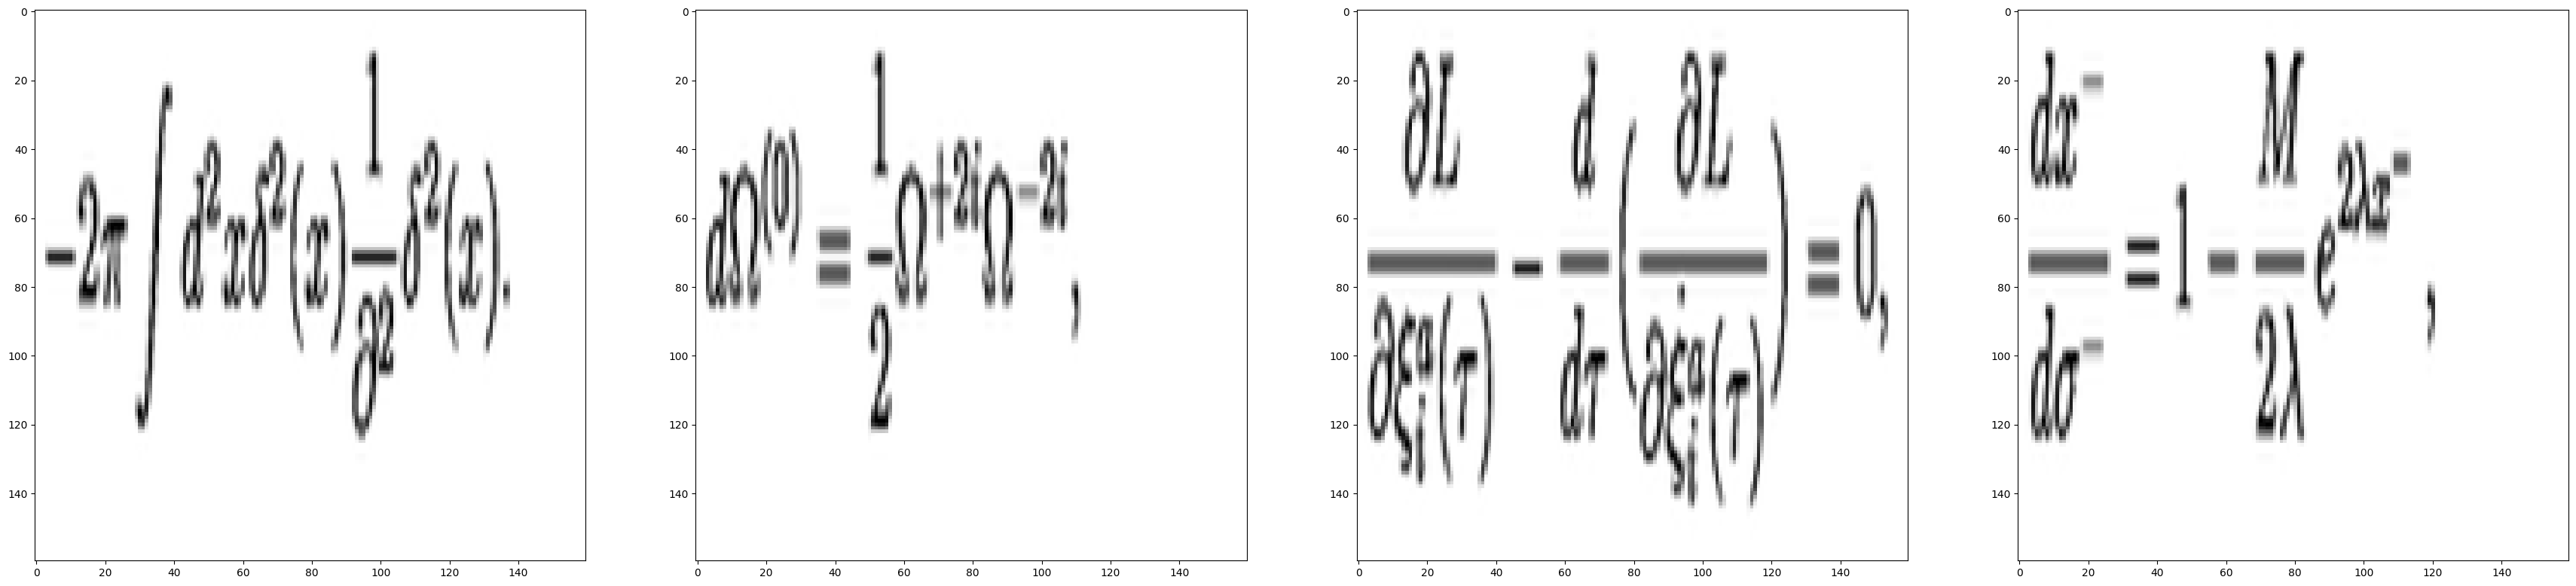

In [71]:
from IPython.display import display, Math, Latex
displayPreds = lambda Y: display(Math(Y))

step = 0

fig = plt.figure(figsize=(100, 100))

for ds in test_ds.shuffle(100):
    images = ds[0]

    num_image = images.shape[0]
    for i in range(4):
        image = images[i].numpy()
        grid_size = max(int(np.ceil(num_image / 9)), 9)
        ax = fig.add_subplot(6, grid_size, i + 1)
        img = ax.imshow(images[i].numpy(), cmap='gray')

        result = model.simple_gen(image, temperature=0.0)
        displayPreds(result)

    step += 1
    break

Split the output back into tokens:

In [81]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [82]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 8, 43, 676]),
 TensorShape([1, 8, 43, 676]),
 TensorShape([1, 8, 43, 676]),
 TensorShape([1, 8, 43, 676])]

In [83]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=26, width=26,
    reduction='mean')

In [84]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(43,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        ], dtype=float32)>

In [85]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(128, 64))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/5)), 5)
      ax = fig.add_subplot(6, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i], fontsize=64))
      img = ax.imshow(image, cmap='gray')
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(), clim=[0.0, np.max(map)])

    plt.tight_layout()
    plt.savefig("attention_maps.jpg")

In [86]:
plot_attention_maps(image, str_tokens, attention_maps)

In [87]:
def run_and_show_attention(self, image, temperature=0.0):
    """
    Generates text and displays attention maps for a given image.

    Args:
        image: The input image.
        temperature: The temperature parameter for text generation.
    """
    result_txt = self.simple_gen(image, temperature)
    str_tokens = result_txt.split()
    str_tokens.append('[END]')

    attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
    attention_maps = tf.concat(attention_maps, axis=0)
    attention_maps = einops.reduce(
        attention_maps,
        'batch heads sequence (height width) -> sequence height width',
        height=26, width=26,
        reduction='mean')

    plot_attention_maps(image / 255, str_tokens, attention_maps)
    t = plt.suptitle(result_txt)
    t.set_y(1.05)

# Add the run_and_show_attention method to the Captioner class
Captioner.run_and_show_attention = run_and_show_attention

In [88]:
run_and_show_attention(model, image)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
